In [2]:
!pip install roboflow
!pip install ultralytics
!pip install fpdf2
!pip install python-docx



  Using cached python_docx-1.1.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached lxml-5.3.0-cp312-cp312-macosx_10_9_x86_64.whl.metadata (3.8 kB)
Using cached python_docx-1.1.2-py3-none-any.whl (244 kB)
Using cached lxml-5.3.0-cp312-cp312-macosx_10_9_x86_64.whl (4.4 MB)


In [2]:
#importer le dataset
from roboflow import Roboflow
rf = Roboflow(api_key="mc58NbkSLazeKKtRUTqT")
project = rf.workspace("pfe-uh2gz").project("pfe1-qai05")
version = project.version(10)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pfe1-10 in yolov8:: 100%|██████████| 324/324 [00:00<00:00, 693.61it/s]



image 1/1 /Users/ivanchristopherbanfou/Desktop/Lettres-en-lumi-re-approche-page-entiere/FRAD021_00001_H_MALTEREG_000504_0024.png: 512x640 2 bodys, 1 pageNumber, 328.7ms
Speed: 19.0ms preprocess, 328.7ms inference, 26.5ms postprocess per image at shape (1, 3, 512, 640)


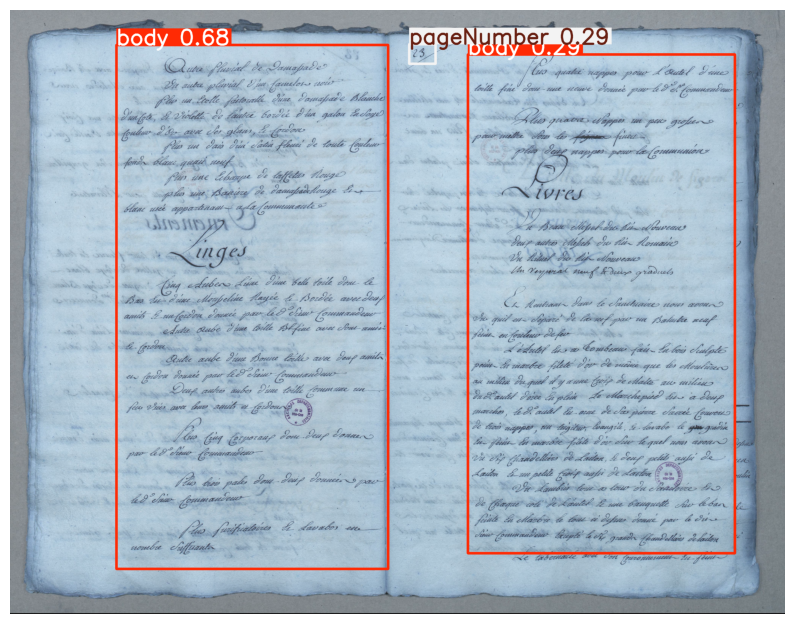

In [ ]:
#lancer une inférence
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Charger le modèle (remplacez 'yolov8n.pt' par votre modèle si vous avez entraîné le vôtre)
model = YOLO('best.pt')

# Chemin de l'image à tester
image_path = './FRAD021_00001_H_MALTEREG_000504_0024.png'

# Effectuer la détection
results = model(image_path)

# Afficher le résultat
# Convertir l'image pour Matplotlib (RGB)
result_image = results[0].plot()

# Afficher avec Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()


In [3]:
#lancer un entrainement
from ultralytics import YOLO
# Charger le modèle YOLOv8 pré-entrainé
model = YOLO('yolov8n.pt')  # Assurez-vous d'avoir le fichier YOLOv8 ici
#  clé API
# Lancer l'entrainement
model.train(data="./pfe1-10/data.yaml", epochs=100, batch=16, imgsz=640,val=True)

Ultralytics 8.3.63 🚀 Python-3.12.0 torch-2.2.2 CPU (Intel Core(TM) i5-1030NG7 1.10GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./pfe1-10/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

RuntimeError: Dataset 'pfe1-10/data.yaml' error ❌ 
Dataset 'pfe1-10/data.yaml' images not found ⚠️, missing path '/Users/ivanchristopherbanfou/Desktop/datasets/pfe1-10/valid/images'
Note dataset download directory is '/Users/ivanchristopherbanfou/Desktop/datasets'. You can update this in '/Users/ivanchristopherbanfou/Library/Application Support/Ultralytics/settings.json'

In [ ]:
import os
import json
import cv2
import numpy as np
from ultralytics import YOLO


# Fonction pour calculer l'IoU entre un shape et une bounding box
def calculate_iou(shape_points, bbox):
    x_min, y_min = np.min(shape_points, axis=0)
    x_max, y_max = np.max(shape_points, axis=0)
    shape_bbox = [x_min, y_min, x_max, y_max]

    # Intersection
    x1 = max(shape_bbox[0], bbox[0])
    y1 = max(shape_bbox[1], bbox[1])
    x2 = min(shape_bbox[2], bbox[2])
    y2 = min(shape_bbox[3], bbox[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Union
    shape_area = (shape_bbox[2] - shape_bbox[0]) * (shape_bbox[3] - shape_bbox[1])
    bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    union_area = shape_area + bbox_area - inter_area

    return inter_area / union_area if union_area != 0 else 0


# Fonction pour vérifier si un shape est principalement dans une bounding box
def is_shape_inside_bbox(shape_points, bbox, threshold=0.5):
    x_min, y_min, x_max, y_max = bbox
    total_points = len(shape_points)
    inside_points = 0

    for point in shape_points:
        if x_min <= point[0] <= x_max and y_min <= point[1] <= y_max:
            inside_points += 1

    return (inside_points / total_points) >= threshold


# Fonction principale pour restructurer le json en fonction de la sortie du modèle
def group_shapes_and_visualize(model_path, input_image_path, input_json_path, output_json_path, output_image_path):
    # Charger le modèle YOLO
    model = YOLO(model_path)

    # Charger l'image
    image = cv2.imread(input_image_path)
    if image is None:
        raise FileNotFoundError(f"Impossible de charger l'image {input_image_path}")

    # Effectuer les prédictions sur l'image
    results = model.predict(image)
    results = results[0]

    # Charger le JSON d’entrée contenant les shapes
    with open(input_json_path, 'r',encoding='utf-8') as file:
        data = json.load(file)

    # Initialiser une structure pour les sections détectées
    detected_sections = []
    section_colors = {}  # Stocke les couleurs associées à chaque section
    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_name = model.names[int(box.cls)]
        score = box.conf.item()

        # Générer une couleur unique pour cette section
        color = tuple(np.random.randint(0, 255, 3).tolist())
        section_colors[f"{class_name}_{i + 1}"] = color

        # Ajouter les sections détectées
        detected_sections.append({
            "name": f"{class_name}_{i + 1}",
            "bbox": [x1, y1, x2, y2],
            "confidence": score
        })

    # Initialiser un regroupement par sections
    sections = {section["name"]: {"bbox": section["bbox"], "shapes": [], "color": section_colors[section["name"]]} for section in detected_sections}

    # Associer chaque shape à une section en fonction de l'IoU et de l'appartenance géométrique
    for shape in data.get("shapes", []):
        shape_points = np.array(shape["points"]).reshape(-1, 2)
        ious = []

        # Comparer chaque shape avec les bounding boxes détectées et stocker les IoUs
        for section in detected_sections:
            section_bbox = section["bbox"]
            iou = calculate_iou(shape_points, section_bbox)
            ious.append((iou, section))

        # Trier les sections par IoU
        ious.sort(key=lambda x: x[0], reverse=True)

        best_section = ious[0][1] if ious[0][0] > 0 else None
        second_best_section = ious[1][1] if len(ious) > 1 else None

        # Vérifier si le shape est géométriquement dans la meilleure bounding box
        if best_section and is_shape_inside_bbox(shape_points, best_section["bbox"]):
            sections[best_section["name"]]["shapes"].append(shape)
        elif second_best_section and is_shape_inside_bbox(shape_points, second_best_section["bbox"]):
            sections[second_best_section["name"]]["shapes"].append(shape)

    # Construire la structure finale regroupée
    grouped_data = {
        "imagePath": data.get("imagePath", input_image_path),
        "imageWidth": data.get("imageWidth"),
        "imageHeight": data.get("imageHeight"),
        "sections": [{"name": name, "bbox": section["bbox"], "shapes": section["shapes"], "color": section["color"]} for name, section in sections.items()]
    }

    # Sauvegarder le JSON regroupé
    with open(output_json_path, 'w', encoding='utf-8') as file:
        json.dump(grouped_data, file, indent=4, ensure_ascii=False)

    # Tracer les masks et les bounding boxes détectées
    for section in grouped_data["sections"]:
        color = section["color"]  # Utiliser la couleur associée à la section

        # Tracer les shapes
        for shape in section["shapes"]:
            points = np.array(shape["points"], dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

        # Tracer la bounding box de la section
        x1, y1, x2, y2 = section["bbox"]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, section["name"], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Sauvegarder l'image annotée
    cv2.imwrite(output_image_path, image)
    print(f"Image annotée sauvegardée dans {output_image_path}")







# Exemple d'appel de la fonction
model_path = './best.pt'
#chemin vers l'image
input_image_path = 'FRAD021_C_03003_00014.png'
#chemin vers l'ancien json
input_json_path = 'FRAD021_C_03003_00014.json'
output_json_path = 'nouveau_fichier.json'
output_image_path = 'image_annotée.jpg'

# Appliquer le modèle et restructurer le JSON
group_shapes_and_visualize(model_path, input_image_path, input_json_path, output_json_path, output_image_path)


0: 512x640 2 bodys, 2 marges, 1 pageNumber, 2 signatures, 191.8ms
Speed: 12.0ms preprocess, 191.8ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)
Image annotée sauvegardée dans image_annotée.jpg


In [7]:
from fpdf import FPDF
import json

class PDF(FPDF):
    def __init__(self):
        super().__init__()
        # Ajout de la police Unicode pour toutes les variantes
        self.add_font("FreeSerif", style="", fname="/Users/ivanchristopherbanfou/Downloads/PFE2/freeserif/FreeSerif.ttf",uni=True)
        self.add_font("FreeSerif", style="B", fname="/Users/ivanchristopherbanfou/Downloads/PFE2/freeserif/FreeSerif.ttf",uni=True)  # Version en gras
        self.add_font("FreeSerif", style="I", fname="/Users/ivanchristopherbanfou/Downloads/PFE2/freeserif/FreeSerif.ttf",uni=True)  # Version en italique
        self.add_font("FreeSerif", style="BI", fname="/Users/ivanchristopherbanfou/Downloads/PFE2/freeserif/FreeSerif.ttf",uni=True)  # Version en gras italique
        self.set_auto_page_break(auto=True, margin=15)

    def header(self):
        self.set_font("FreeSerif", "B", 12)
        self.cell(0, 10, 'PDF traduction', 0, 1, 'C')
        self.ln(10)

    def add_section(self, section_name):
        self.set_font("FreeSerif", "B", 16)
        self.cell(0, 10, section_name, 0, 1, 'L')
        self.ln(5)

    def add_label(self, label):
        self.set_font("FreeSerif", "", 12)
        self.multi_cell(0, 10, label)
        self.ln(2)
#générer le pdf à partir du nouveau json
def generate_pdf_from_json(json_file, output_file):
    with open(json_file, 'r',encoding='utf-8') as file:
        data = json.load(file)

    pdf = PDF()
    pdf.add_page()

    for section in data.get("sections", []):
        # Ajouter le nom de la section comme titre
        section_name = section.get("name", "Section sans titre")
        pdf.add_section(section_name)

        # Ajouter les labels comme contenu
        for shape in section.get("shapes", []):
            label = shape.get("label", "Label manquant")
            pdf.add_label(label)

    # Générer le fichier PDF
    pdf.output(output_file)
    print(f"PDF généré avec succès : {output_file}")

# Remplacez 'FreeSerif.ttf' par le chemin de votre fichier de police et assurez-vous d'avoir les versions bold et italic si nécessaire
generate_pdf_from_json('nouveau_fichier.json', 'output.pdf')


"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.


PDF généré avec succès : output.pdf


In [3]:
from docx import Document
import json

def generate_word_from_json(json_file, output_file):
    # Charger les données JSON
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Créer un document Word
    document = Document()

    # Ajouter un titre principal
    document.add_heading('Traduction du JSON', level=1)

    # Parcourir les sections
    for section in data.get("sections", []):
        # Ajouter le titre de la section
        section_name = section.get("name", "Section sans titre")
        document.add_heading(section_name, level=2)

        # Ajouter les labels comme contenu
        for shape in section.get("shapes", []):
            label = shape.get("label", "Label manquant")
            document.add_paragraph(label)

    # Sauvegarder le fichier Word
    document.save(output_file)
    print(f"Word généré avec succès : {output_file}")

# Remplacez 'nouveau_fichier.json' par le chemin de votre fichier JSON d'entrée
generate_word_from_json('nouveau_fichier.json', 'output.docx')


Word généré avec succès : output.docx
